In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [32]:
train = pd.read_csv('../datasets/train.csv')
test = pd.read_csv('../datasets/test.csv')

In [33]:
train.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries,smoking
0,0,55,165,60,81.0,0.5,0.6,1,1,135,...,40,75,16.5,1,1.0,22,25,27,0,1
1,1,70,165,65,89.0,0.6,0.7,2,2,146,...,57,126,16.2,1,1.1,27,23,37,1,0
2,2,20,170,75,81.0,0.4,0.5,1,1,118,...,45,93,17.4,1,0.8,27,31,53,0,1
3,3,35,180,95,105.0,1.5,1.2,1,1,131,...,38,102,15.9,1,1.0,20,27,30,1,0
4,4,30,165,60,80.5,1.5,1.0,1,1,121,...,44,93,15.4,1,0.8,19,13,17,0,1


In [34]:
test.head()

,id,age,height(cm),weight(kg),waist(cm),eyesight(left),eyesight(right),hearing(left),hearing(right),systolic,...,triglyceride,HDL,LDL,hemoglobin,Urine protein,serum creatinine,AST,ALT,Gtp,dental caries
0,159256,40,165,70,84.0,1.2,1.2,1,1,130,...,186,49,115,14.2,1,0.9,19,25,32,0
1,159257,80,160,60,93.0,1.0,1.0,2,2,144,...,158,35,104,13.0,1,1.1,20,12,24,0
2,159258,60,170,70,86.5,0.6,0.7,1,1,117,...,173,39,88,15.4,1,1.4,38,60,36,0
3,159259,40,160,50,67.0,0.3,0.4,1,1,116,...,47,75,128,14.5,1,0.6,25,18,10,1
4,159260,40,170,75,89.4,1.0,0.9,1,1,132,...,100,39,123,16.5,1,1.0,30,39,27,1


In [35]:
train.columns

Index(['id', 'age', 'height(cm)', 'weight(kg)', 'waist(cm)', 'eyesight(left)',
       'eyesight(right)', 'hearing(left)', 'hearing(right)', 'systolic',
       'relaxation', 'fasting blood sugar', 'Cholesterol', 'triglyceride',
       'HDL', 'LDL', 'hemoglobin', 'Urine protein', 'serum creatinine', 'AST',
       'ALT', 'Gtp', 'dental caries', 'smoking'],
      dtype='object')

In [36]:
train = train.drop(columns = 'id', axis = 1)
test = test.drop(columns = 'id', axis = 1)

In [37]:
train.shape, test.shape

((159256, 23), (106171, 22))

<Axes: >

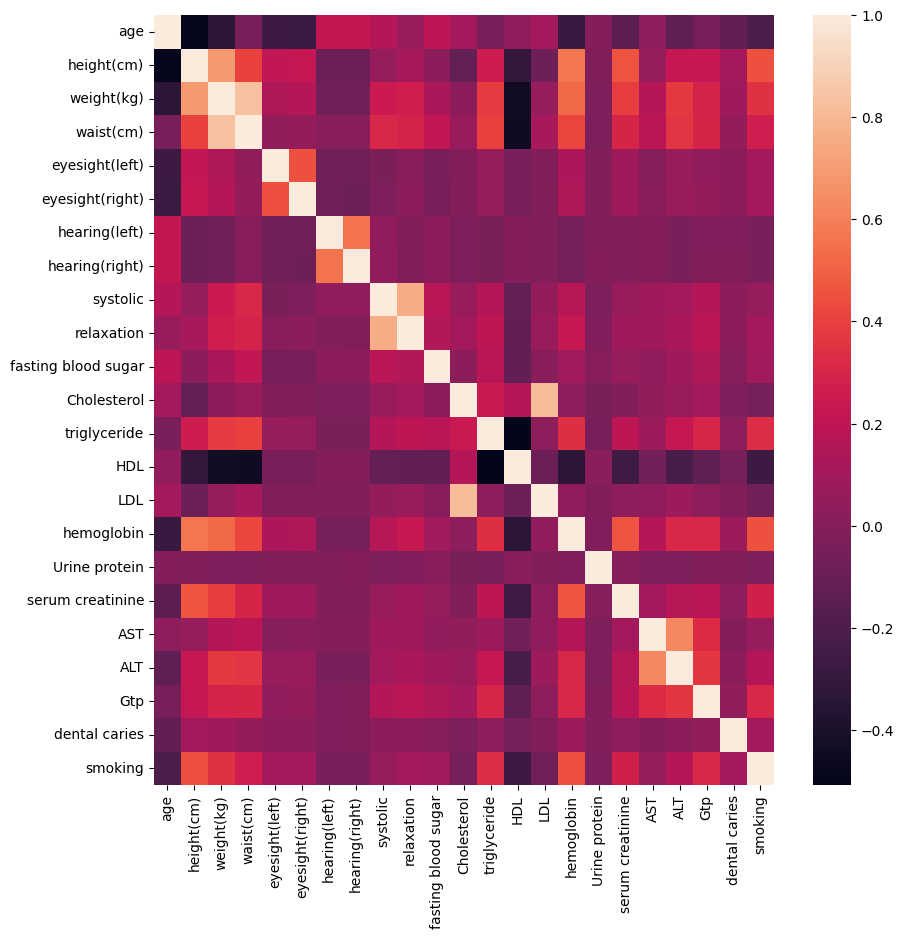

In [38]:
plt.figure(figsize = (10,10))
sns.heatmap(train.corr())

In [39]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

X = train.drop(columns = 'smoking')
y = train['smoking']

LR = LogisticRegression()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

LR.fit(X_train, y_train)

pred = LR.predict(X_test)

print(accuracy_score(pred, y_test))

0.7356837875172674


/home/yusuf/workspace/projects/smoking-detection/.venv/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 100 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=100).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [42]:
test_df = pd.read_csv('../datasets/test.csv')
predictions = LR.predict(test)

LR_submission = pd.DataFrame({
    'id': test_df['id'],
    'smoking': predictions
})

LR_submission.to_csv('../submissions/LR.csv', index = False)

In [43]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score
from scipy.stats import uniform, randint

param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.3),
    'subsample': uniform(0.7, 0.3),
    'colsample_bytree': uniform(0.7, 0.3)
}

xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')

random_search = RandomizedSearchCV(estimator=xgb, param_distributions=param_dist,
                                   n_iter=50, cv=5, scoring='accuracy',
                                   verbose=1, random_state=42, n_jobs=-1)

random_search.fit(X_train, y_train)

best_model = random_search.best_estimator_

pred = best_model.predict(X_test)
print("Best Parameters:", random_search.best_params_)
print("Accuracy:", accuracy_score(y_test, pred))


Fitting 5 folds for each of 50 candidates, totalling 250 fits


/home/yusuf/workspace/projects/smoking-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:59:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yusuf/workspace/projects/smoking-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:59:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yusuf/workspace/projects/smoking-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:59:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/home/yusuf/workspace/projects/smoking-detection/.venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [11:59:41] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_

Best Parameters: {'colsample_bytree': np.float64(0.7692681476866446), 'learning_rate': np.float64(0.0823076398078035), 'max_depth': 6, 'n_estimators': 298, 'subsample': np.float64(0.8829989973347863)}
Accuracy: 0.7814265980158231


In [44]:
test_df = pd.read_csv('../datasets/test.csv')
predictions = best_model.predict(test)

xgb_submission = pd.DataFrame({
    'id': test_df['id'],
    'smoking': predictions
})

LR_submission.to_csv('../submissions/XGBC.csv', index = False)